In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df1 = pd.read_csv('Test1.csv',index_col='Timestamp',parse_dates=True)
df2 = pd.read_csv('Test2.csv',index_col='Timestamp',parse_dates=True)
df3 = pd.read_csv('Test3.csv',index_col='Timestamp',parse_dates=True)

In [61]:
df = pd.concat([df1,df2,df3])
df.head()

,min,max,range,mean,RMS,standard deviation,skewness,kurtosis,crest factor,form factor,fault
Timestamp,,,,,,,,,,,
2003-10-22 12:06:24,-0.720,0.388,1.108,-0.094593,0.124614,0.081124,-0.029995,1.069717,-4.101789,-1.317370,normal
2003-10-22 12:06:24,-0.564,0.701,1.265,-0.093880,0.117493,0.070650,0.220132,3.066925,-7.466969,-1.251523,normal
2003-10-22 12:09:13,-0.654,0.388,1.042,-0.094903,0.123811,0.079517,-0.070080,1.162128,-4.088401,-1.304613,normal
2003-10-22 12:09:13,-0.491,0.581,1.072,-0.093891,0.116833,0.069531,0.126508,2.001798,-6.188019,-1.244340,normal
2003-10-22 12:14:13,-0.623,0.317,0.940,-0.096187,0.125246,0.080219,-0.041649,0.986819,-3.295670,-1.302116,normal


In [62]:
df.shape

(46480, 11)

In [63]:
df['fault'].value_counts()

normal                43809
roller defect          1378
inner race failure      654
outer race failure      639
Name: fault, dtype: int64

<AxesSubplot:xlabel='fault', ylabel='count'>

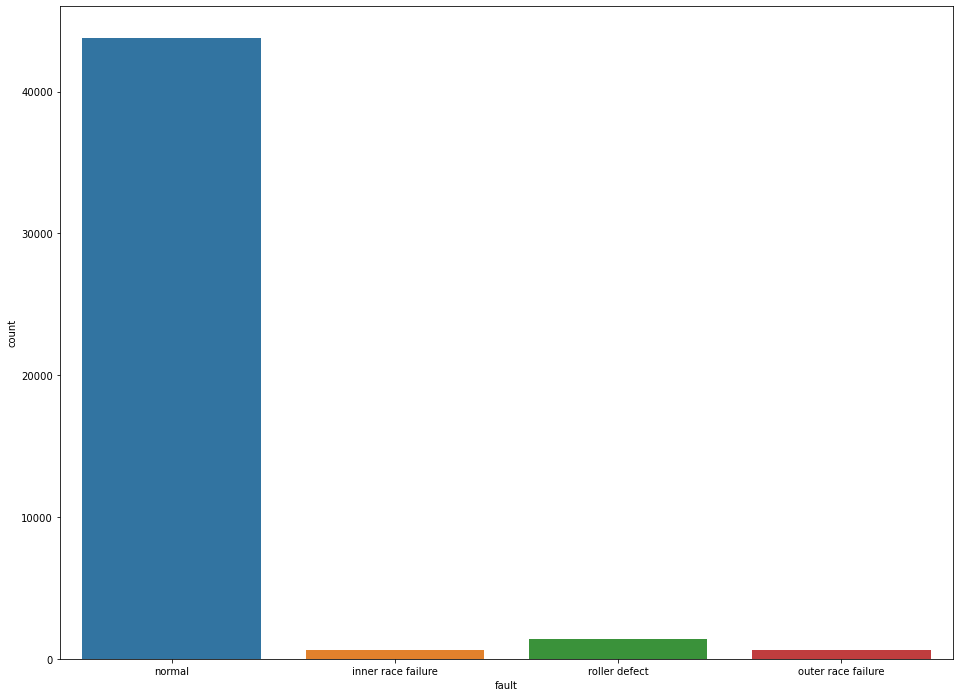

In [64]:
plt.figure(figsize=(16,12))
sns.countplot(data=df,x=df['fault'])

Its observed that the dataset is very much imbalanced and hence needs to be balanced. Making use of random sampler for balancing from imblearn package.

In [67]:
from imblearn.under_sampling import RandomUnderSampler

In [68]:
X = df.drop('fault',axis=1)
y = df['fault']

In [69]:
y.value_counts()

normal                43809
roller defect          1378
inner race failure      654
outer race failure      639
Name: fault, dtype: int64

In [70]:
y.shape

(46480,)

In [71]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [78]:
y_res

0       inner race failure
1       inner race failure
2       inner race failure
3       inner race failure
4       inner race failure
               ...        
2551         roller defect
2552         roller defect
2553         roller defect
2554         roller defect
2555         roller defect
Name: fault, Length: 2556, dtype: object

In [72]:
y_res.value_counts()

inner race failure    639
normal                639
outer race failure    639
roller defect         639
Name: fault, dtype: int64

<AxesSubplot:xlabel='fault', ylabel='count'>

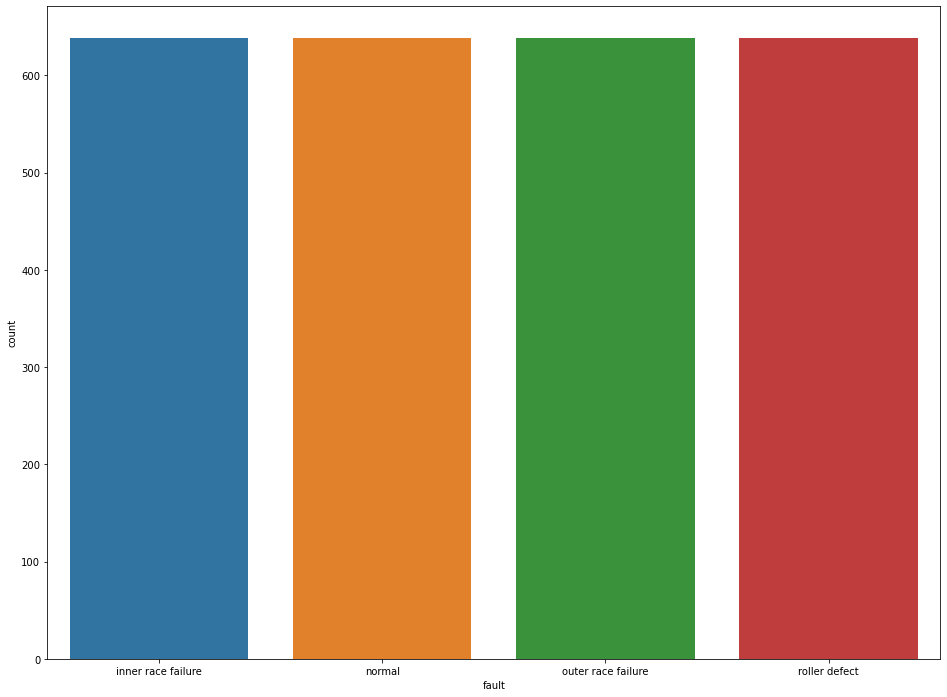

In [76]:
plt.figure(figsize=(16,12))
sns.countplot(x=y_res)

test train split

In [66]:
from sklearn.model_selection import train_test_split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, shuffle=True, random_state=42)

In [136]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

In [137]:
scale_X_train = scaler.fit_transform(X_train)
scale_X_test = scaler.fit_transform(X_test)

## using classifier models like random forest classifier or decision tree classifier

In [138]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [139]:
import warnings
warnings.filterwarnings("ignore")

In [145]:
parameters_rfc = {'max_depth': np.arange(2,10,1),
                    'min_samples_split': np.arange(2,10,1),
                    'min_samples_leaf' : np.arange(1,3,1),
                    'n_estimators' : np.arange(10,100,10) }

grid_rfc = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid = parameters_rfc, 
                        n_jobs= -1, 
                        refit=True, 
                        cv=5, 
                        return_train_score = True)

grid_rfc.fit(scale_X_train,y_train)

print('Best model parameters: ', grid_rfc.best_params_)
print('Best model: ',grid_rfc.best_estimator_)

Best model parameters:  {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 40}
Best model:  RandomForestClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=40)


In [147]:
rfc = RandomForestClassifier(max_depth = 9,
                                min_samples_leaf=2,
                                min_samples_split=5,
                                n_estimators=40)
rfc.fit(scale_X_train,y_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=40)

In [148]:
rfc_test_pred = rfc.predict(scale_X_test)
rfc_train_pred = rfc.predict(scale_X_train)

In [98]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, ConfusionMatrixDisplay

In [149]:
print('Training set \n',classification_report(y_train,rfc_train_pred))
print('Test set \n', classification_report(y_test,rfc_test_pred))

Training set 
                     precision    recall  f1-score   support

inner race failure       0.96      0.99      0.98       476
            normal       0.99      0.98      0.99       479
outer race failure       0.99      1.00      0.99       489
     roller defect       1.00      0.96      0.98       473

          accuracy                           0.98      1917
         macro avg       0.98      0.98      0.98      1917
      weighted avg       0.98      0.98      0.98      1917

Test set 
                     precision    recall  f1-score   support

inner race failure       0.88      0.91      0.90       163
            normal       0.94      0.91      0.92       160
outer race failure       0.92      1.00      0.96       150
     roller defect       0.93      0.85      0.89       166

          accuracy                           0.92       639
         macro avg       0.92      0.92      0.92       639
      weighted avg       0.92      0.92      0.91       639

